## Wind Speed Function
we have the following function for determining growing and killing degree days (respectively):
$$
g(h) = \begin{cases}
0, &h\leq 10\\
h-10, &10\leq h\leq 28\\
18, &28 \leq h\\
\end{cases}
\qquad
g(h) = \begin{cases}
0, &h \leq 28 \\
h-28, &h > 28
\end{cases}
$$
where the computed value for the mean temperature is then multiplied over the length of the growing season. We will base our initial function for killing wind speeds on a similar formulation:
$$g_k(w) = \begin{cases}
0, &w \leq 15 \\
(w - 15), &w > 15
\end{cases}$$
where $t$ is the estimated duration of the event (rounded to the nearest hours).
We also might want to compute a "growing wind" variable:
$$g_g(w) = \begin{cases}
0, &w \leq 2 \\
w - 2, &2 \leq w \leq 7 \\
12-w, &w > 7 \\
0, &w > 12
\end{cases}$$

In [1]:
### Import basic libraries
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
%matplotlib inline
import time
import glob
from statsmodels.formula.api import ols

In [2]:
def ws_func(w):
    if w <= 10:
        return 0
    else:
        return w-10
ws_func_v = np.vectorize(ws_func)

In [3]:
# Let's read in a lot of wind data!
county_yield = pd.read_csv("USA_county_yield_gsw.csv")
kansas = county_yield.loc[county_yield['State'] == 'KANSAS']
filenames = glob.glob('C:\\Users\\18595\\wind_project\\data_60\\*.csv')

In [4]:
def compress_data(height = 'wind speed at 10m (m/s)', filenames = filenames):
    #print(height)
    data_all = []
    for i in range(len(filenames)):
        wind_i = pd.read_csv(filenames[i], low_memory=False)
        county_name = filenames[i].split("_")[-2].upper()
        county_data = kansas.loc[kansas['County'] == county_name]
        c_year = county_data["Year"].unique()
        w_year = wind_i["Year"].unique()
        years = np.intersect1d(c_year, w_year)
        county_gs = county_data[county_data["Year"].isin(years)]
        wind_gs = wind_i[wind_i["Year"].isin(years)]
        wind_gs = wind_gs[(wind_gs["Month"] >= 4) & (wind_gs["Month"] <= 10)]
        for y in years:
            wind_gs_y = wind_gs.loc[wind_gs["Year"] == y]
            county_gs_y = county_gs.loc[county_gs["Year"] == y]
            w_gs_y = wind_gs_y[height]
            killing_winds = np.sum(ws_func_v(w_gs_y))
            data = np.append(county_gs_y.iloc[:,[1, 5, 12, 14, 15]].values, [killing_winds]).tolist()
            data_all.append(data)
    return(data_all)
def evaluate(data):
    data_arr = np.array(data)
    ln_yield = data_arr[:,2].astype(np.float64)
    covariates = data_arr[:,3:7].astype(np.float64)
    #Linear Model
    print("Linear Model")
    model = LinearRegression()
    model.fit(covariates, ln_yield)
    y_preds = model.predict(covariates)
    print("\tr-squared:", r2_score(ln_yield, y_preds))
    print("\tCoefficients", model.coef_)
    print("\tIntercept:", model.intercept_)
    #Hmm that's not great...let's try a polynomial transform?
    print("Polynomial Model")
    poly = PolynomialFeatures(3)
    cov_poly = poly.fit_transform(covariates[:,-1].reshape(-1,1))
    #print(cov_poly)
    covariates_poly = np.hstack((covariates[:,0:1], cov_poly))
    model = LinearRegression()
    model.fit(covariates_poly, ln_yield)
    y_preds = model.predict(covariates_poly)
    print("\tr-squared:", r2_score(ln_yield, y_preds))
    print("\tCoefficients", model.coef_)
    print("\tIntercept:", model.intercept_)

In [5]:
data_all = compress_data()
data_all_df = pd.DataFrame(data_all, columns = ['Year', 'County', 'logYield', 'GDD', 'KDD', 'KWE'])
print(data_all_df.head())
##wind coefficient is still positive at 40m, 60m, 80m, 100m (error at 120m)

   Year    County  logYield        GDD       KDD   KWE
0  2007  ANDERSON  4.736198  10.335781  0.506006  26.0
1  2009  ANDERSON  4.744932   8.835716  0.309374  14.0
2  2010  ANDERSON  4.448516  10.086300  0.664116  26.0
3  2011  ANDERSON  3.873282  10.074523  1.045294  41.0
4  2012  ANDERSON  3.563883  11.103476  1.090869   7.0


In [6]:
data_df = pd.DataFrame(columns = ['Year', 'County', 'logYield', 'GDD', 'KDD', 'KWE', 'KWEResiduals', 'logYieldResiduals'])
counties = list(data_all_df['County'].unique()); print(counties)
for i in range(len(counties)):
    data = data_all_df[data_all_df['County'] == counties[i]].copy()
    covariates = data['Year'].astype(float).values.reshape(-1, 1)
    ys = data['KWE'].astype(float)
    model = LinearRegression()
    model.fit(covariates, ys)
    y_preds = model.predict(covariates)
    residuals = ys - y_preds
    data.loc[:, 'KWEResiduals'] = residuals # added this line!
    ys2 = data['logYield'].astype(float)
    model.fit(covariates, ys2)
    y_preds2 = model.predict(covariates)
    residuals2 = ys2 - y_preds2
    data.loc[:, 'logYieldResiduals'] = residuals2 #added this line!
    data_df = data_df.append(data)

['ANDERSON', 'ATCHISON', 'BROWN', 'CHEROKEE', 'COFFEY', 'DOUGLAS', 'HARVEY', 'JACKSON', 'LYON', 'MCPHERSON', 'MIAMI', 'MONTGOMERY', 'MORRIS', 'NEMAHA', 'OSAGE', 'POTTAWATOMIE', 'SHAWNEE', 'SUMNER', 'WILSON']


Using just windspeed residuals
	coefficient [-0.00132124]
	r-squared: 0.008722977358068706
Using GDD, KDD, and Windspeed Residuals
	coefficient [ 6.56135449e-02 -1.01357028e+00  3.98838759e-04]
	r-squared: 0.5616708650028056


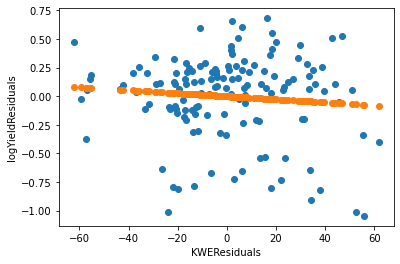

In [7]:
data_df
model = LinearRegression()
covariate = data_df['KWEResiduals'].astype(float).values.reshape(-1,1)
model.fit(covariate, data_df['logYieldResiduals'])
yield_preds = model.predict(covariate)
plt.scatter(covariate, data_df['logYieldResiduals'])
plt.scatter(covariate, yield_preds)
plt.xlabel("KWEResiduals")
plt.ylabel("logYieldResiduals")
print('Using just windspeed residuals')
print("\tcoefficient", model.coef_)
print("\tr-squared:", r2_score(data_df["logYieldResiduals"], yield_preds))
covariates_all = data_df.loc[:,['GDD', 'KDD', 'KWEResiduals']] #
model.fit(covariates_all, data_df['logYieldResiduals'])
yield_preds2 = model.predict(covariates_all)
print('Using GDD, KDD, and Windspeed Residuals')
print("\tcoefficient", model.coef_)
print("\tr-squared:", r2_score(data_df['logYieldResiduals'], yield_preds2))

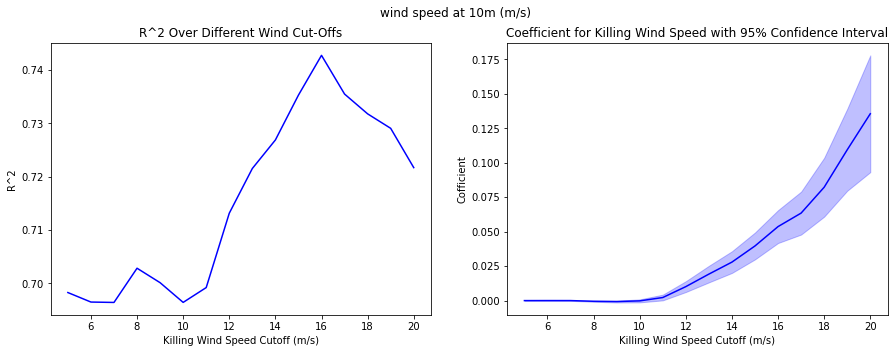

In [8]:
height = 'wind speed at 10m (m/s)'
rsquareds = []
wind_coefs = []
wind_coef_error = []
cutoffs = np.linspace(5, 20, 16)
for i in cutoffs:
    print("i:", i, end='\r')
    def ws_func(w):
        if w <= i:
            return 0
        else:
            return w-i
    ws_func_v = np.vectorize(ws_func)
    data_all = compress_data(height)
    data_all_df = pd.DataFrame(data_all, columns = ['Year', 'County', 'logYield', 'GDD', 'KDD', 'KWE'])
    data_df = pd.DataFrame(columns=['Year', 'County', 'logYield', 'GDD', 'KDD', 'KWE', 'KWEResiduals', 'logYieldResiduals'])
    counties = list(data_all_df['County'].unique()) #; print(counties)
    for i in range(len(counties)):
        data = data_all_df[data_all_df['County'] == counties[i]].copy()
        covariates = data['Year'].astype(float).values.reshape(-1, 1)
        ys = data['KWE'].astype(float)
        model = LinearRegression()
        model.fit(covariates, ys)
        y_preds = model.predict(covariates)
        residuals = ys - y_preds
        data.loc[:, 'KWEResiduals'] = residuals # added this line!
        ys2 = data['logYield'].astype(float)
        model.fit(covariates, ys2)
        y_preds2 = model.predict(covariates)
        residuals2 = ys2 - y_preds2
        data.loc[:, 'logYieldResiduals'] = residuals2 #added this line!
        data_df = data_df.append(data)
    data_df['logYield'] = data_df['logYield'].astype(float)
    data_df['GDD'] = data_df['GDD'].astype(float)
    data_df['KDD'] = data_df['KDD'].astype(float)
    fit = ols('logYieldResiduals ~ C(Year) + C(County) + GDD + KDD + KWEResiduals', data=data_df).fit() #+ KWEResiduals
    rsquareds.append(fit.rsquared_adj)
    wind_coefs.append(fit.params['KWEResiduals'])
    wind_coef_error.append(fit.bse['KWEResiduals'])
    #print(fit.summary())  
    #print("\n")
#plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle(height)
ax[0].plot(cutoffs, rsquareds, color = 'blue')
ax[0].set_title("R^2 Over Different Wind Cut-Offs")
ax[0].set_ylabel("R^2")
ax[0].set_xlabel("Killing Wind Speed Cutoff (m/s)")
ax[1].plot(cutoffs, wind_coefs, color = 'blue')
lower_bound = [x1-x2 for (x1,x2) in zip(wind_coefs, wind_coef_error)]
upper_bound = [x1+x2 for (x1,x2) in zip(wind_coefs, wind_coef_error)]
ax[1].fill_between(cutoffs, lower_bound, upper_bound, color = 'blue', alpha = 0.25)
ax[1].set_title("Coefficient for Killing Wind Speed with 95% Confidence Interval")
ax[1].set_ylabel("Cofficient")
ax[1].set_xlabel("Killing Wind Speed Cutoff (m/s)");

The following regressions were performed on compressed 5-minute data.

In [9]:
filenames2 = glob.glob('C:\\Users\\18595\\wind_project\\data_5\\*.csv')
data_all2 = compress_data(height = 'wind_10ms', filenames = filenames2)
evaluate(data_all2)

Linear Model
	r-squared: 0.6427744243562157
	Coefficients [ 0.10060036 -1.34248222  0.01665996]
	Intercept: 4.414737328744987
Polynomial Model
	r-squared: 0.3629332891458631
	Coefficients [-3.26983116e-01  3.39420332e-15 -3.35095255e-02 -1.12181151e-03
  3.23603796e-04]
	Intercept: 7.75620834302959


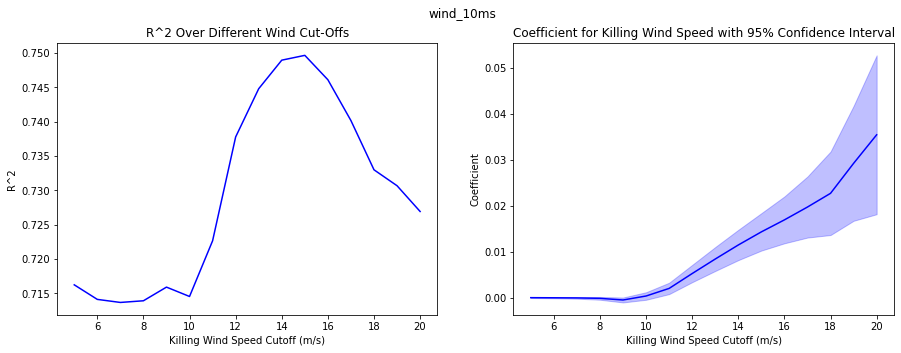

In [10]:
height = 'wind_10ms'
rsquareds = []
wind_coefs = []
wind_coef_error = []
cutoffs = np.linspace(5, 20, 16)
for i in cutoffs:
    print("i:", i, end='\r')
    def ws_func(w):
        if w <= i:
            return 0
        else:
            return w-i
    ws_func_v = np.vectorize(ws_func)
    data_all = compress_data(height = height, filenames = filenames2)
    data_all_df = pd.DataFrame(data_all, columns = ['Year', 'County', 'logYield', 'GDD', 'KDD', 'KWE'])
    data_df = pd.DataFrame(columns=['Year', 'County', 'logYield', 'GDD', 'KDD', 'KWE', 'KWEResiduals', 'logYieldResiduals'])
    counties = list(data_all_df['County'].unique()) #; print(counties)
    for i in range(len(counties)):
        data = data_all_df[data_all_df['County'] == counties[i]].copy()
        covariates = data['Year'].astype(float).values.reshape(-1, 1)
        ys = data['KWE'].astype(float)
        model = LinearRegression()
        model.fit(covariates, ys)
        y_preds = model.predict(covariates)
        residuals = ys - y_preds
        data.loc[:, 'KWEResiduals'] = residuals # added this line!
        ys2 = data['logYield'].astype(float)
        model.fit(covariates, ys2)
        y_preds2 = model.predict(covariates)
        residuals2 = ys2 - y_preds2
        data.loc[:, 'logYieldResiduals'] = residuals2 #added this line!
        data_df = data_df.append(data)
    data_df['logYield'] = data_df['logYield'].astype(float)
    data_df['GDD'] = data_df['GDD'].astype(float)
    data_df['KDD'] = data_df['KDD'].astype(float)
    fit = ols('logYieldResiduals ~ C(Year) + C(County) + GDD + KDD + KWEResiduals', data=data_df).fit() #+ KWEResiduals
    rsquareds.append(fit.rsquared_adj)
    wind_coefs.append(fit.params['KWEResiduals'])
    wind_coef_error.append(fit.bse['KWEResiduals'])
    #print(fit.summary())  
    #print("\n")
#plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle(height)
ax[0].plot(cutoffs, rsquareds, color = 'blue')
ax[0].set_title("R^2 Over Different Wind Cut-Offs")
ax[0].set_ylabel("R^2")
ax[0].set_xlabel("Killing Wind Speed Cutoff (m/s)")
ax[1].plot(cutoffs, wind_coefs, color = 'blue')
lower_bound = [x1-x2 for (x1,x2) in zip(wind_coefs, wind_coef_error)]
upper_bound = [x1+x2 for (x1,x2) in zip(wind_coefs, wind_coef_error)]
ax[1].fill_between(cutoffs, lower_bound, upper_bound, color = 'blue', alpha = 0.25)
ax[1].set_title("Coefficient for Killing Wind Speed with 95% Confidence Interval")
ax[1].set_ylabel("Coefficient")
ax[1].set_xlabel("Killing Wind Speed Cutoff (m/s)");

## Try Number 2 after Jon's Feedback!
Let's start with some time series:

In [11]:
#also plot time series of yield and wind (growing season) average) --> done!
#county fixed effects and then also county specific linear trend 
def plot_data(filenames = filenames, height = 'wind speed at 10m (m/s)'):
    data_plt = []
    for i in range(len(filenames)):
        wind_i = pd.read_csv(filenames[i])
        county_name = filenames[i].split("_")[-2].upper()
        county_data = kansas.loc[kansas['County'] == county_name]
        c_year = county_data["Year"].unique()
        w_year = wind_i["Year"].unique()
        years = np.intersect1d(c_year, w_year)
        county_gs = county_data[county_data["Year"].isin(years)]
        wind_gs = wind_i[wind_i["Year"].isin(years)]
        wind_gs = wind_gs[(wind_gs["Month"] >= 4) & (wind_gs["Month"] <= 10)]
        for y in years:
            wind_gs_y = wind_gs.loc[wind_gs["Year"] == y]
            county_gs_y = county_gs.loc[county_gs["Year"] == y]
            w_gs_y = wind_gs_y[height]
            average_winds = np.mean(w_gs_y)
            data = np.append(county_gs_y.iloc[:,[1,5,12,14,15]].values, average_winds).tolist() #,12,14,15
            data_plt.append(data)
    return data_plt

In [12]:
data_plt = np.array(plot_data())
df_plt = pd.DataFrame(data_plt, columns = ['Year', 'County', 'Log-Yield', 'GDD', 'KDD', 'Average Windspeed (m/s)'])
print(df_plt.head())

C:\Users\18595\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3263: DtypeWarning: Columns (40) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


   Year    County           Log-Yield                 GDD                KDD  \
0  2007  ANDERSON     4.7361984483945    10.3357809588762  0.506006266665724   
1  2009  ANDERSON    4.74493212836325    8.83571633568811  0.309374387971491   
2  2010  ANDERSON   4.448516375942719    10.0863004483531  0.664115796895266   
3  2011  ANDERSON  3.8732821771117205     10.074522600119   1.04529374904993   
4  2012  ANDERSON    3.56388296393925  11.103476030369999   1.09086915197851   

  Average Windspeed (m/s)  
0      3.5051499221183646  
1       3.567359813084114  
2       3.720846962616825  
3      3.9220151869158832  
4      3.7356542056074766  


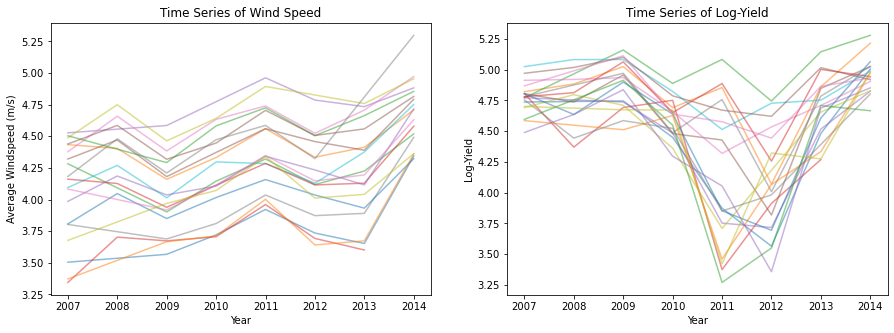

In [13]:
colors = list(df_plt['County'].unique())
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i in range(0 , len(colors)):
    data = df_plt[df_plt['County'] == colors[i]]
    ax[0].plot(data['Year'].astype(float), data['Average Windspeed (m/s)'].astype(float), label=colors[i], alpha = 0.5)
    ax[1].plot(data['Year'].astype(float), data['Log-Yield'].astype(float), alpha = 0.5)
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Average Windspeed (m/s)")
ax[0].set_title("Time Series of Wind Speed")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Log-Yield")
ax[1].set_title("Time Series of Log-Yield");

   Year      County           Log-Yield                 GDD  \
0  2007  MONTGOMERY  4.5849674786705705  10.698778911443501   
1  2009  MONTGOMERY    4.51085950651685   9.420280792894369   
2  2010  MONTGOMERY  4.6269316777695995  10.594253882320801   
3  2011  MONTGOMERY  3.4594662897861297    10.6874620117677   
4  2012  MONTGOMERY    4.06560209335645    11.3832622755811   

                  KDD Average Windspeed (m/s)  
0  0.5273850723078151        7.31817172897198  
1   0.477715607840491       7.808839563862919  
2   0.811667653517798       8.074028426791283  
3    1.32249681197357         8.5695346573209  
4    1.19445247615138       8.064521028037431  


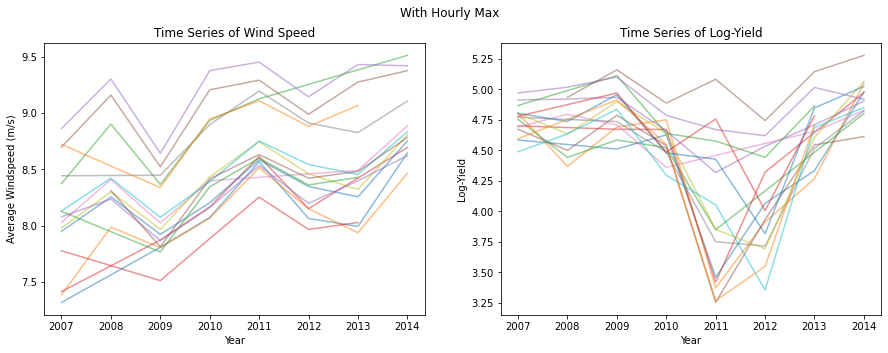

In [14]:
data_plt = np.array(plot_data(filenames2, 'wind_100ms'))
df_plt = pd.DataFrame(data_plt, columns = ['Year', 'County', 'Log-Yield', 'GDD', 'KDD', 'Average Windspeed (m/s)'])
print(df_plt.head())
counties = list(df_plt['County'].unique())
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i in range(0 , len(counties)):
    data = df_plt[df_plt['County'] == counties[i]]
    ax[0].plot(data['Year'].astype(float), data['Average Windspeed (m/s)'].astype(float), label=counties[i], alpha = 0.5)
    ax[1].plot(data['Year'].astype(float), data['Log-Yield'].astype(float), alpha = 0.5)
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Average Windspeed (m/s)")
ax[0].set_title("Time Series of Wind Speed")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Log-Yield")
ax[1].set_title("Time Series of Log-Yield")
fig.suptitle("With Hourly Max");

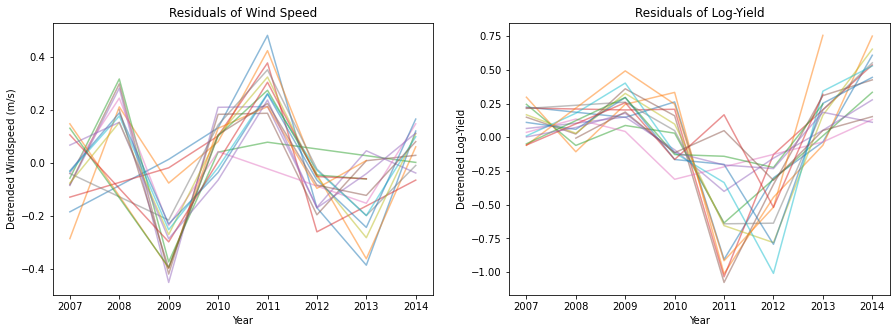

In [15]:
data_df = pd.DataFrame(columns = ['Year', 'County', 'Log-Yield', 'GDD', 'KDD', 'Average Windspeed (m/s)', 'Windspeed Residuals', 'Log-Yield Residuals'])
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i in range(len(counties)):
    data = df_plt[df_plt['County'] == counties[i]].copy()
    covariates = data['Year'].astype(float).values.reshape(-1, 1)
    ys = data['Average Windspeed (m/s)'].astype(float)
    model = LinearRegression()
    model.fit(covariates, ys)
    y_preds = model.predict(covariates)
    residuals = ys - y_preds
    data.loc[:, 'Windspeed Residuals'] = residuals # added this line!
    ax[0].plot(covariates, residuals, alpha = 0.5)
    ys2 = data['Log-Yield'].astype(float)
    model.fit(covariates, ys2)
    y_preds2 = model.predict(covariates)
    residuals2 = ys2 - y_preds2
    data.loc[:, 'Log-Yield Residuals'] = residuals2 #added this line!
    ax[1].plot(covariates, residuals2, alpha = 0.5)
    data_df = data_df.append(data)
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Detrended Windspeed (m/s)")
ax[0].set_title("Residuals of Wind Speed")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Detrended Log-Yield")
ax[1].set_title("Residuals of Log-Yield");

This appears to check out! Specifically we see a peak in wind speed residuals in 2011 which matches the negative peak in the log-yield residuals.

Using just windspeed residuals
	coefficient [-0.63695816]
	r-squared: 0.11279884606653345
Using GDD, KDD, and Windspeed Residuals
	coefficient [ 0.08605091 -1.09443928 -0.13969758]
	r-squared: 0.6056970092408949


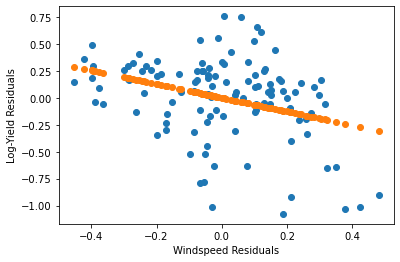

In [16]:
model = LinearRegression()
covariate = data_df['Windspeed Residuals'].astype(float).values.reshape(-1,1)
model.fit(covariate, data_df['Log-Yield Residuals'])
yield_preds = model.predict(covariate)
plt.scatter(covariate, data_df['Log-Yield Residuals'])
plt.scatter(covariate, yield_preds)
plt.xlabel("Windspeed Residuals")
plt.ylabel("Log-Yield Residuals")
print('Using just windspeed residuals')
print("\tcoefficient", model.coef_)
print("\tr-squared:", r2_score(data_df['Log-Yield Residuals'], yield_preds))
covariates_all = data_df.loc[:,['GDD', 'KDD', 'Windspeed Residuals']] #
model.fit(covariates_all, data_df['Log-Yield Residuals'])
yield_preds2 = model.predict(covariates_all)
print('Using GDD, KDD, and Windspeed Residuals')
print("\tcoefficient", model.coef_)
print("\tr-squared:", r2_score(data_df['Log-Yield Residuals'], yield_preds2))

The difference in $r^2$ between temperature and temperature with windspeed residuals only provides marginal improvement in $r^2$. We do, however, finally observe the expected coefficient for windspeed (that is, negative).

# Next up is polynomial regression!

Using GDD, KDD, and Powers of Windspeed up to 3
	coefficient [ 0.15748312 -1.39305354 -0.23600816 -0.08275375  0.00847668]
	r-squared: 0.6589095961690365


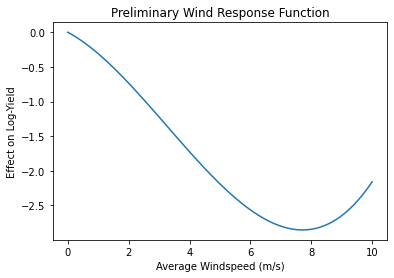

In [17]:
#This is done with the raw mean
test = df_plt['Average Windspeed (m/s)'].astype(float).values.reshape(-1,1)
poly = PolynomialFeatures(3, include_bias = False)
test_poly = poly.fit_transform(test)
df_plt.loc[:,'Windspeed^2'] = test_poly[:,1]
df_plt.loc[:,'Windspeed^3'] = test_poly[:,2]
covariates_all = df_plt.loc[:,['GDD', 'KDD', 'Average Windspeed (m/s)', 'Windspeed^2', 'Windspeed^3']] #
model.fit(covariates_all, data_df['Log-Yield Residuals'])
yield_preds3 = model.predict(covariates_all)
print('Using GDD, KDD, and Powers of Windspeed up to 3')
print("\tcoefficient", model.coef_)
print("\tr-squared:", r2_score(data_df['Log-Yield Residuals'], yield_preds3))
def response_func(x):
    return model.coef_[2]*x + model.coef_[3]*x**2 + model.coef_[4]*x**3
xlim = np.linspace(0, 10, 100)
plt.plot(xlim, response_func(xlim))
plt.xlabel("Average Windspeed (m/s)")
plt.ylabel("Effect on Log-Yield")
plt.title("Preliminary Wind Response Function");